# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Цель проекта: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, на основе предоставленых исторических данных о поведении клиентов и расторжении договоров с банком. 

Задачи проекта: построить модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. Проверить *F1*-меру на тестовой выборке самостоятельно.

Дополнительно: измерять *AUC-ROC*, сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

Подгрузим необходимые библиотеки и модули:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

Загружаем датасет, смотрим первые пять строк:

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим общую информацию по датасету:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Разделим датасет на набор признаков и целевой признак:

In [5]:
features = df.drop('Exited', axis=1)
features.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


In [6]:
target = df['Exited']
target.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

___Произведем необходимые преобразования признаков___

In [7]:
# Заменим значения в колонке с полом со строковых типов на числовые:
gender = {'Male': 0, 'Female': 1}
features['Gender'] = features['Gender'].map(gender)

In [8]:
# напишем функцию, которая пригодится в дальнейшем при исследовании дисбаланса классов
def transform_features(feature):
    # В колонке с количеством объектов недвижимости есть пропуски. Будем считать, что если количество объектов не указано, 
    # то их нет
    feature['Tenure'] = feature['Tenure'].fillna(0)
        
    # Для построения модели не пригодятся данные о фамилии клиента, номер строки записи
    # и id пользователя, можно их удалить и в дальнейшем не учитывать
    feature = feature.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
    
    # Для возможности обучения модели необходимо предобразовать все строковые данные в числа
    # Данные о географическом положении важны для анализа, произведем прямое кодирование этих признаков
    feature = pd.get_dummies(feature, drop_first=True)
    
    # В данных есть количественные признаки с разными разбросами значений
    # Отмасштабируем признаки с помощью класса StandardScaler:
    scaler = StandardScaler()
    features_scal = scaler.fit_transform(feature)
    
    return features_scal

In [9]:
features_scal = transform_features(features)

In [10]:
features_scal

array([[-0.32622142,  1.09598752,  0.29351742, ...,  0.02188649,
        -0.57873591, -0.57380915],
       [-0.44003595,  1.09598752,  0.19816383, ...,  0.21653375,
        -0.57873591,  1.74273971],
       [-1.53679418,  1.09598752,  0.29351742, ...,  0.2406869 ,
        -0.57873591, -0.57380915],
       ...,
       [ 0.60498839,  1.09598752, -0.27860412, ..., -1.00864308,
        -0.57873591, -0.57380915],
       [ 1.25683526, -0.91241915,  0.29351742, ..., -0.12523071,
         1.72790383, -0.57380915],
       [ 1.46377078,  1.09598752, -1.04143285, ..., -1.07636976,
        -0.57873591, -0.57380915]])

## Вывод:

1. Данные загружены корректно, объекты содержат как категориальные, так и количественные признаки.
2. Исходный датасет разбит на признаки объекта и выделен целевой признак.
3. Категориальные признаки преобразованы в количественные (изменены столбец с полом и выполнено прямое кодирование столбца с географическим положением).
4. Обработаны пропуски.
5. Признаки отмасштабированы, так как имеется очень большой разброс в значениях признаков.

# 2. Исследование задачи

Разобъем объекты и целевые признаки на валидационную, тестовую + обучающую выборки без учета дисбаланса.

In [11]:
X_train, X_test_val, y_train, y_test_val = train_test_split(features_scal, target, random_state=42, test_size=0.3)

Разобъем на отдельные тестовую и валидационную выборки полученные выборки с признаками:

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=42, test_size=0.5)

Данные готовы для обучения модели. Обучим модель без учета дисбаланса. Возьмем алгоритм случайного леса.

In [13]:
# зададим начальные настройки модели
model_dis = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)

In [14]:
# обучим модель и посмотрим на матрицу ошибок
model_dis.fit(X_train, y_train)
confusion_matrix(y_val, model_dis.predict(X_val))

array([[1194,    6],
       [ 256,   44]])

Количество истинных нулей - _1194_ , количество ошибочно определенных нулей - _256_ . Это очень много, наша модель плохо определяет единицы.

In [15]:
# посмотрим на соотношение нулей и единиц в обучающих целевых признаках
y_train.value_counts(normalize=True)

0    0.792429
1    0.207571
Name: Exited, dtype: float64

Посчитаем полноту и точность предсказаний модели:


In [16]:
def pre_rec(target, predictions):    
    print('Точность предсказаний модели равна: ', precision_score(target, predictions))
    print('Полнота предсказаний модели равна: ', recall_score(target, predictions))

In [17]:
pre_rec(y_val, model_dis.predict(X_val))

Точность предсказаний модели равна:  0.88
Полнота предсказаний модели равна:  0.14666666666666667


Полнота мала. Посчитаем метрику f1:

In [18]:
f1_score(y_val, model_dis.predict(X_val))

0.25142857142857145

In [19]:
# построим кривую неточностей

# сохраним вероятности определения единиц в отдельную переменную
probabilities_one_valid = model_dis.predict_proba(X_val)[:, 1]

# напишем функцию для отрисовки ROC кривой для использования в дальнейшем
def plot_roc(target_val, prob_one_val, title='модели случайного леса (дисбаланс классов)'):
    fpr, tpr, thresholds = roc_curve(target_val, prob_one_val)
        
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr)
    
    # ROC кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.xlabel('Ложно положительные ответы')
    plt.ylabel('Истинно положительные ответы')
    
    plt.title('ROC-кривая ' + title)
    plt.show()
    print('Значение AUC ROC - ', roc_auc_score(target_val, prob_one_val))

Построим ROC кривую.

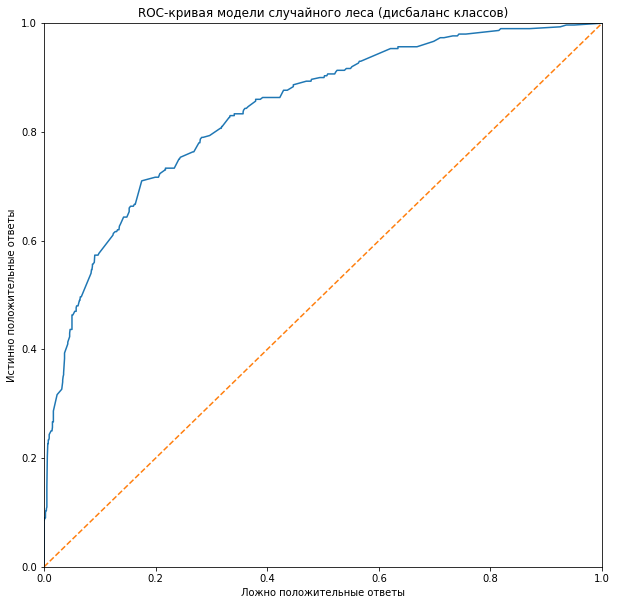

Значение AUC ROC -  0.8380833333333334


In [20]:
plot_roc(y_val, probabilities_one_valid)

Попробуем обучить модель дерева решений для сравнения.

In [21]:
# зададим дереву решений некоторые первоначальные гиперпараметры
model_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [22]:
# вычислим метрику f1
f1_score(y_val, model_tree.predict(X_val))

0.5338809034907598

In [23]:
pre_rec(y_val, model_tree.predict(X_val))

Точность предсказаний модели равна:  0.6951871657754011
Полнота предсказаний модели равна:  0.43333333333333335


Результаты у дерева решений на несбалансированных данных лучше, чем у случайного леса. Попробуем логистическую регрессию:

In [24]:
model_reg = LogisticRegression(random_state=42, solver='lbfgs')
model_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
# вычислим метрику f1
f1_score(y_val, model_reg.predict(X_val))

0.2987951807228916

In [26]:
pre_rec(y_val, model_reg.predict(X_val))

Точность предсказаний модели равна:  0.5391304347826087
Полнота предсказаний модели равна:  0.20666666666666667


Построим кривые неточностей

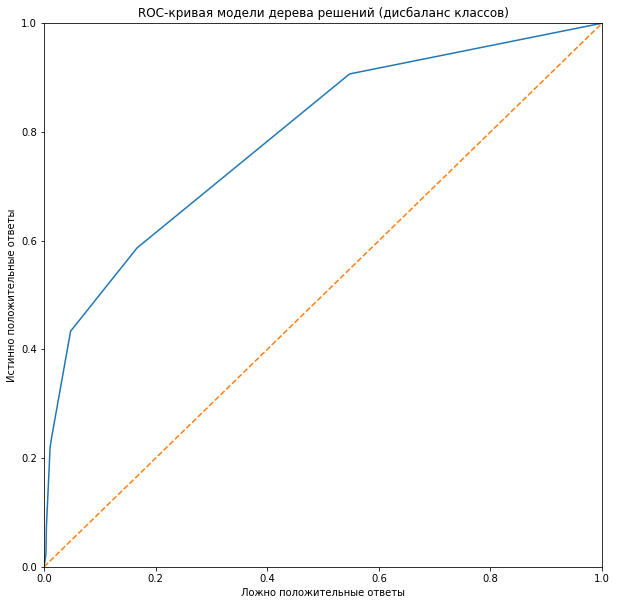

Значение AUC ROC -  0.7895875


In [27]:
plot_roc(y_val, model_tree.predict_proba(X_val)[:, 1], title='модели дерева решений (дисбаланс классов)')

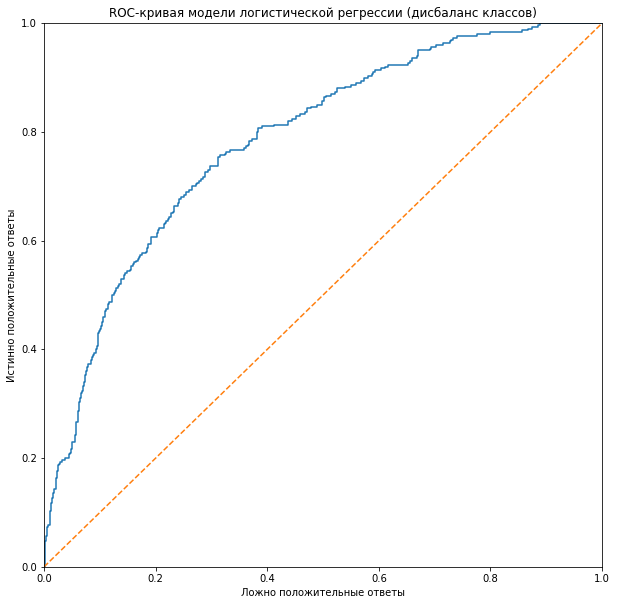

Значение AUC ROC -  0.7837055555555555


In [28]:
plot_roc(y_val, model_reg.predict_proba(X_val)[:, 1], title='модели логистической регрессии (дисбаланс классов)')

## Вывод:

1. Соотношение классов в исходном датасете - 80% нулей и 20% единиц, что говорит о явном дисбалансе классов.
2. ROC кривая предсказаний выглядит плохо:
  - для модели случайного леса верхний левый угол графика слишком скруглен и не стремится к углу, что подтверждается низким значением площади под кривой, но самым большим значением (0,83) по сравнению с другими исследованными моделями.
  - для модели дерева решений получена самое высокое значение метрики f1 (0.53), но кривая ROC срезана и стала еще меньше стремиться к единице, площадь под ней уменьшилась на 5 %.
  - модель логистической регрессии оказалась пока самой худшей - при незначительном увеличении f1(0.29), площадь под кривой roc также уменьшилась на 5 %.
4. Полученные значение меры f1 не удовлетворяют требованиям проекта.

# 3. Борьба с дисбалансом

## 3.1 Борьба с дисбалансом методом повышения размерности признаков и взвешивания классов

Улучшим качество модели с учетом дисбаланса классов. Изпользуем повышение размерности признаков.

In [29]:
# напишем функцию для повышения размерности
def upsample(features, target, repeat):
    
    # выделяем выборки с классами
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # повторяем необходимое количество раз признаки со значением целевого признака, равным 1
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # возвращаем перемешанные выборки
    return shuffle(features_upsampled, target_upsampled, random_state = 42)

Разделим исходные признаки на обучающие, тестовые и валидационные выборки. Выберем размер тренеровочных данных = 70 %:

In [30]:
X_train, X_test_val, y_train, y_test_val = train_test_split(features, target, random_state=42, test_size=0.3)

Выделим в отдельные переменные тестовую и валидационную выборки:

In [31]:
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=42, test_size=0.5)

Для обучения модели с повышением размерности нужно повысить размерность только у обучающего набора:

In [32]:
X_train_up, y_train_up = upsample(X_train, y_train, 3)

Посмотрим на баланс классов в выборках с выбранной размерностью:

In [33]:
y_train_up.value_counts(normalize=True)

0    0.559964
1    0.440036
Name: Exited, dtype: float64

Для построения модели нужно выполнить преобразования всех наборов - очистка, масштабирование и прямое кодирование признаков:

In [34]:
X_test = transform_features(X_test)
X_val = transform_features(X_val)
X_train_up = transform_features(X_train_up)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Данные готовы для тренеровки и настройки модели. Обучим модель классификатора случайный лес с теми же данными, что были у модели до изменения баланса классов.

In [35]:
model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
model.fit(X_train_up, y_train_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Построим матрицу ошибок:

In [36]:
confusion_matrix(y_val, model.predict(X_val))

array([[987, 213],
       [ 94, 206]])

В полученной модели полнота хороша, но точность не радует. Строим ROC.

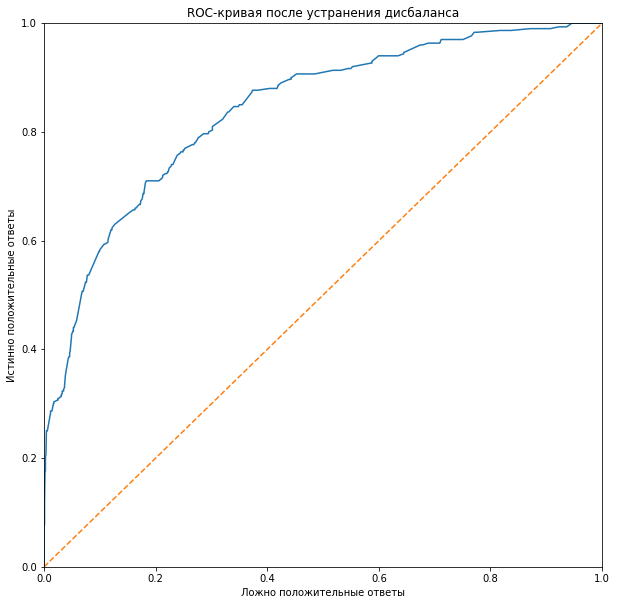

Значение AUC ROC -  0.8400277777777779


In [37]:
plot_roc(y_val, model.predict_proba(X_val)[:, 1], 'после устранения дисбаланса')

Площадь под кривой ROC получилась еще меньше, чем на модели с дисбалансом класов. Посчитаем метрики.

In [38]:
f1_score(y_val, model.predict(X_val))

0.5730180806675937

Как видно, значение метрики f1 значительно выросло (в 2 раза по сравнению с моделью с дисбалансом классов). Посчитаем отдельно точность и полноту предсказаний для модели:

In [39]:
pre_rec(y_val, model.predict(X_val))

Точность предсказаний модели равна:  0.4916467780429594
Полнота предсказаний модели равна:  0.6866666666666666


Попробуем обучить модели логистической регрессии и дерева решений, посмотрим как у них изменились значения f1 и auc:

In [40]:
# обучим модель логистической регрессии и произведем расчет метрик
model_lin = LogisticRegression(random_state=42, solver='lbfgs')
model_lin.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# рассчитаем f1 на валидационных данных
f1_score(y_val, model_lin.predict(X_val))

0.503562945368171

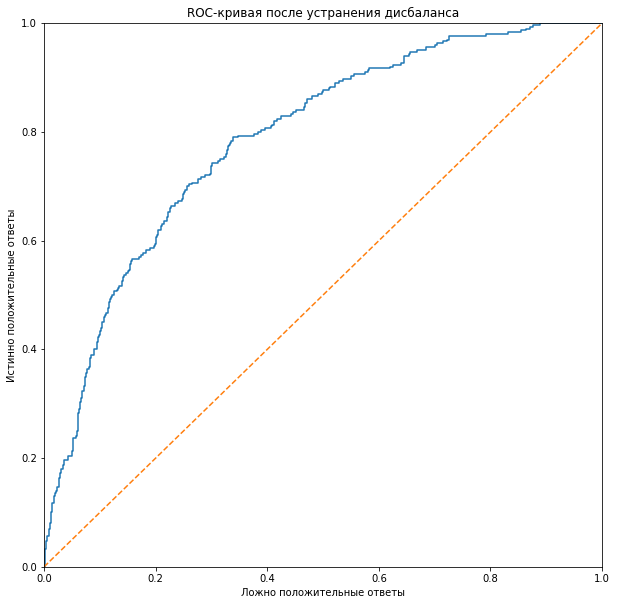

Значение AUC ROC -  0.7867111111111111


In [42]:
plot_roc(y_val, model_lin.predict_proba(X_val)[:, 1], 'после устранения дисбаланса')

In [43]:
# обучим модель дерева решений и произведем расчет метрик
model_dtree = DecisionTreeClassifier(random_state=42, max_depth=3)
model_dtree.fit(X_train_up, y_train_up)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [44]:
# рассчитаем f1 на валидационных данных
f1_score(y_val, model_dtree.predict(X_val))

0.5313531353135315

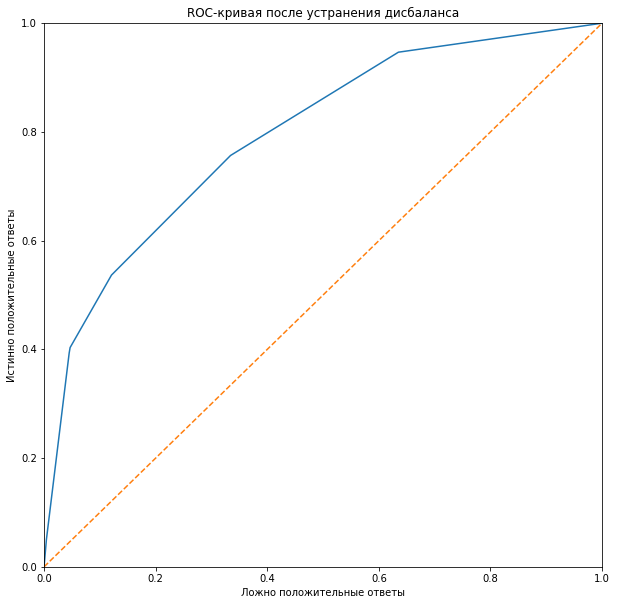

Значение AUC ROC -  0.7941097222222223


In [45]:
plot_roc(y_val, model_dtree.predict_proba(X_val)[:, 1], 'после устранения дисбаланса')

Для того, чтобы сделать правильные выводы, попробуем устранить дисбаланс с помощью взвешивания классов при обучении моделей. Обучим также три типа моделей и исследуем изменение f1 и auc, сравнив результаты со способом повышения размерности признаков.

In [46]:
# возьмем модели, которые были ранее рассмотрены и добавим гиперпараметра class_weight
model_lin = LogisticRegression(random_state=42, solver='lbfgs', class_weight='balanced')
model_rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42, class_weight='balanced')
model_dtree = DecisionTreeClassifier(random_state=42, max_depth=3, class_weight='balanced')

In [47]:
# преобразуем признаки X_train
X_train = transform_features(X_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [48]:
# напишем функцию для быстрого расчета метрик и построения roc-кривой
def model_info(model):
    model.fit(X_train, y_train)
    plot_roc(y_val, model.predict_proba(X_val)[:, 1], 'после устранения дисбаланса')
    print('f1-метрика равна: ', f1_score(y_val, model.predict(X_val)))
    pre_rec(y_val, model.predict(X_val))

#### Исследуем модель логистической регрессии

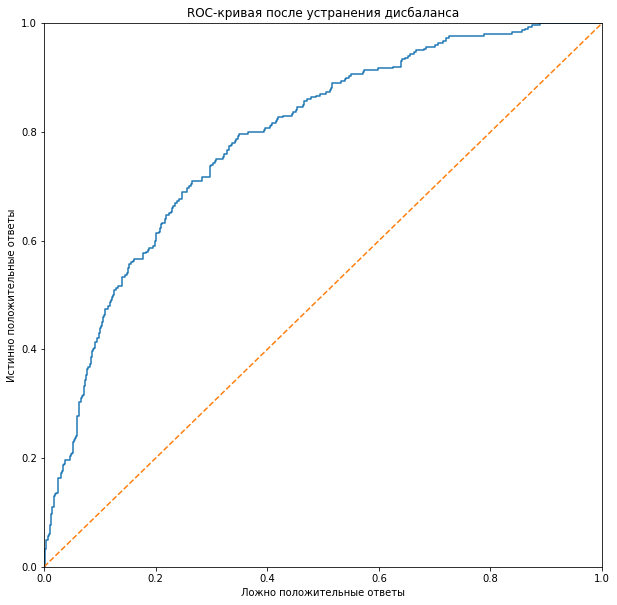

Значение AUC ROC -  0.7867583333333333
f1-метрика равна:  0.5047393364928909
Точность предсказаний модели равна:  0.3915441176470588
Полнота предсказаний модели равна:  0.71


In [49]:
model_info(model_lin)

#### Исследуем модель дерева решений

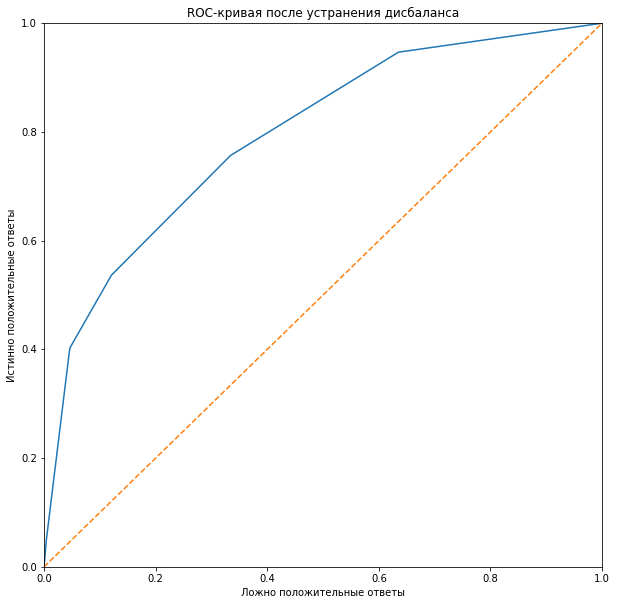

Значение AUC ROC -  0.7941097222222223
f1-метрика равна:  0.4892241379310345
Точность предсказаний модели равна:  0.3614649681528662
Полнота предсказаний модели равна:  0.7566666666666667


In [50]:
model_info(model_dtree)

#### Исследуем модель случайного леса

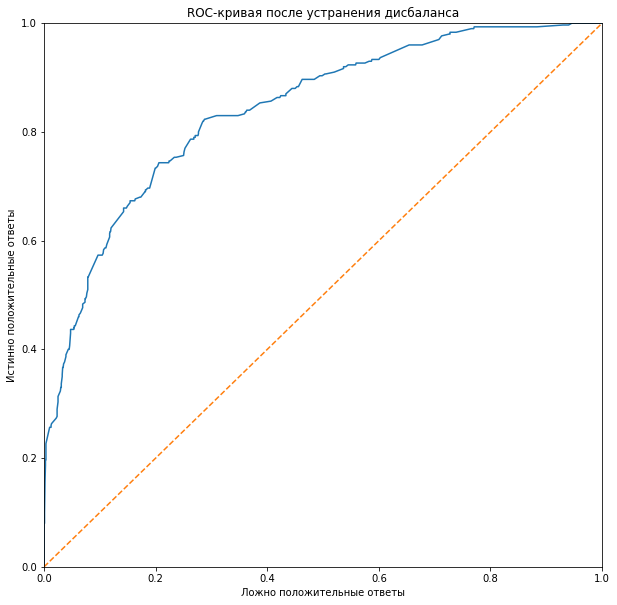

Значение AUC ROC -  0.8407347222222222
f1-метрика равна:  0.563843236409608
Точность предсказаний модели равна:  0.45417515274949083
Полнота предсказаний модели равна:  0.7433333333333333


In [51]:
model_info(model_rf)

### Вывод: 

Рассмотренные методы устранения дисбаланса оказывают примерно одинаковые влияния на качество моделей, но, тем не менее, в данном случае повышение размерности дает небольшой прирост в значении метрик f1 и auc, поэтому будем в дальнейшем использовать выборки с повышеной размерностью признаков.

### Полученные модели можно улучшить, подобрав необходимые гиперпараметры. Воспользуемся решетчатым поисков лучших сочетаний параметров.

In [52]:
# для начала создадим объекты наших моделей без параметров
forest = RandomForestClassifier()
tree = DecisionTreeClassifier()
logreg = LogisticRegression()

# для каждого алгоритма обучения модели определим диапазоны параметров, по которым хотим сделать поиск лучших и запишем
# каждую в свою переменную
param_forest = {
    'max_depth': range(20, 30), 'n_estimators': range(10, 50, 10)
}

param_tree = {
    'max_depth': range(20, 30)
}

param_reg = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

Произведем поиск оптимальных параметров для каждой модели и проанализируем их. Параметр кроссвалидации выберем равным 3 для ускорения расчетов. Метрика - f1-score

In [53]:
grid_forest = GridSearchCV(forest, param_forest, cv=3, scoring='f1')
grid_tree = GridSearchCV(tree, param_tree, cv=3, scoring='f1')
grid_logreg = GridSearchCV(logreg, param_reg, cv=3, scoring='f1')

Подберем лучшие параметры каждой модели:

In [54]:
for grid in (grid_forest, grid_tree, grid_logreg):
    grid.fit(X_train_up, y_train_up)

Посмотрим на лучшие параметры и рассчитаем метрики.

In [55]:
# для логистической регрессии
grid_logreg.best_params_

{'solver': 'newton-cg'}

In [56]:
# для дерева решений
grid_tree.best_params_

{'max_depth': 24}

In [57]:
# для случайного леса
grid_forest.best_params_

{'max_depth': 23, 'n_estimators': 40}

В первом приближении лучшие модели получены. Посмотрим на значения метрик и кривую roc (лучшая модель сохранена в переменную grid).

#### Лучшая модель логистической регрессии

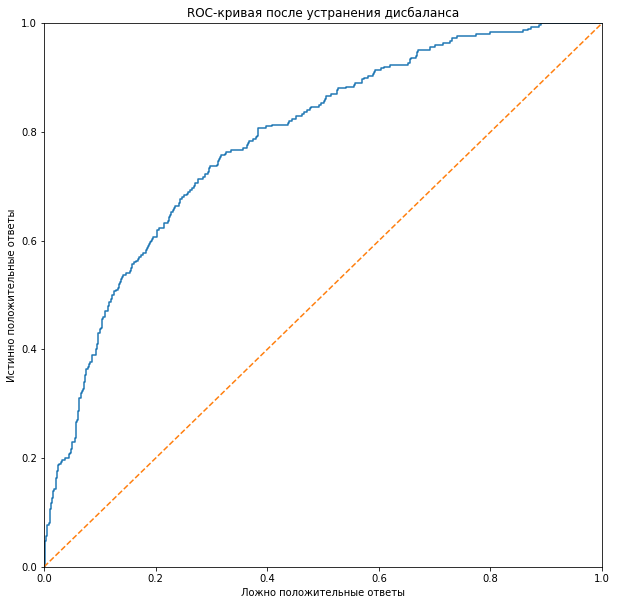

Значение AUC ROC -  0.7834916666666667
f1-метрика равна:  0.29197080291970806
Точность предсказаний модели равна:  0.5405405405405406
Полнота предсказаний модели равна:  0.2


In [58]:
model_info(grid_logreg)

#### Лучшая модель дерева решений

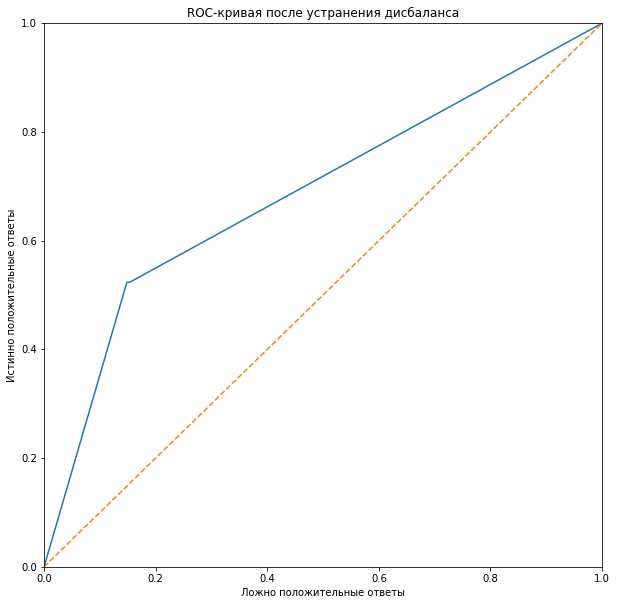

Значение AUC ROC -  0.6863083333333333
f1-метрика равна:  0.4937106918238994
Точность предсказаний модели равна:  0.46726190476190477
Полнота предсказаний модели равна:  0.5233333333333333


In [59]:
model_info(grid_tree)

#### Лучшая модель случайного леса

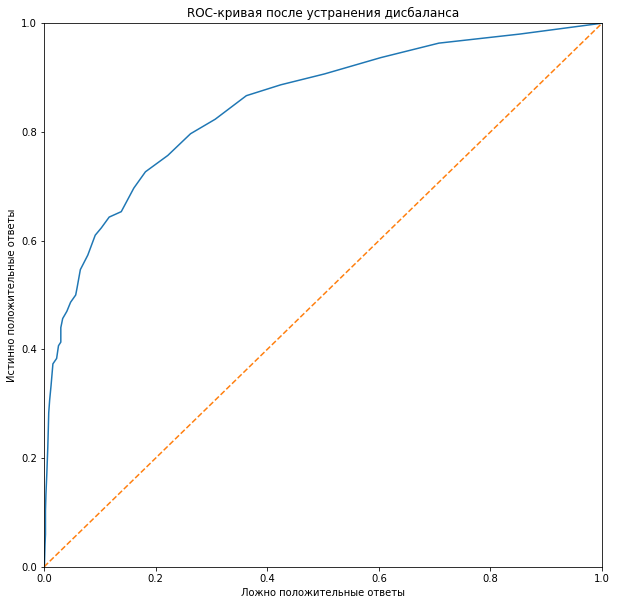

Значение AUC ROC -  0.8487319444444444
f1-метрика равна:  0.5755102040816326
Точность предсказаний модели равна:  0.7421052631578947
Полнота предсказаний модели равна:  0.47


In [60]:
model_info(grid_forest)

## Вывод

1. При изменении балансов классов на соотношение примерно 50 на 50 полнота предсказаний увеличилась, но точность уменьшилась.
2. Значение метрики f1 (среднее гармоническое полноты и точности) увеличилось ~ в 2 раза по сравнению с моделью, обученной на не сбалансированных классах.
3. Расчитаны значения f1 метрики для различных алгоритмов и они равны:
  - LogisticRegression = 0.29 (ухудшилось по сравнению с другим методом обучения)
  - DecisionTreeClassifier = 0.507 (но похоже, что дерево переобучено)
  - RandomForestClassifier = 0.58
3. По предварительному расчету без точной настройки моделей наилучшей моделью для нашей задачи является модель случайного леса. В дальнейшем настраиваем и обучаем только эту модель.

## 3.2 Настройка модели

In [61]:
# посмотрим на изменение метрики f1 score при изменении глубины дерева и количества деревьев
# изменим параметры одновременно для нахождения лучшего соотношения
for depth in range(22, 25, 1):
    for estim in range(40, 50, 1):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=42)
        model.fit(X_train_up, y_train_up)
        print('Значение f1 при глубине {} и количестве деревьев {} => {}'.format(depth, 
                                                                                 estim, 
                                                                                 f1_score(y_val, model.predict(X_val))))

Значение f1 при глубине 22 и количестве деревьев 40 => 0.5920826161790017
Значение f1 при глубине 22 и количестве деревьев 41 => 0.6037099494097808
Значение f1 при глубине 22 и количестве деревьев 42 => 0.5972222222222223
Значение f1 при глубине 22 и количестве деревьев 43 => 0.6030664395229983
Значение f1 при глубине 22 и количестве деревьев 44 => 0.6010362694300518
Значение f1 при глубине 22 и количестве деревьев 45 => 0.5969125214408233
Значение f1 при глубине 22 и количестве деревьев 46 => 0.5965517241379311
Значение f1 при глубине 22 и количестве деревьев 47 => 0.5969125214408233
Значение f1 при глубине 22 и количестве деревьев 48 => 0.5941278065630398
Значение f1 при глубине 22 и количестве деревьев 49 => 0.595890410958904
Значение f1 при глубине 23 и количестве деревьев 40 => 0.5979381443298969
Значение f1 при глубине 23 и количестве деревьев 41 => 0.6067796610169492
Значение f1 при глубине 23 и количестве деревьев 42 => 0.6055363321799307
Значение f1 при глубине 23 и количестве

Первые 3 гиперпараметра выбраны - max_depth = 24, n_estimators = 45. Попробуем изменить максимальное число признаков:

In [62]:
for feat in range(3, 9):
    model = RandomForestClassifier(n_estimators=45, max_depth=24, random_state=42, max_features=feat)
    model.fit(X_train_up, y_train_up)
    print('Значение f1 при максимальном количестве ветвей дерева {} => {}'.format(feat, f1_score(y_val, model.predict(X_val))))

Значение f1 при максимальном количестве ветвей дерева 3 => 0.6122448979591836
Значение f1 при максимальном количестве ветвей дерева 4 => 0.6047297297297298
Значение f1 при максимальном количестве ветвей дерева 5 => 0.5897435897435898
Значение f1 при максимальном количестве ветвей дерева 6 => 0.5970636215334421
Значение f1 при максимальном количестве ветвей дерева 7 => 0.6045016077170419
Значение f1 при максимальном количестве ветвей дерева 8 => 0.5927099841521395


Максимальная величина f1, полученная методом подбора гиперпараметров составила 0,6122. Обучим модель, построим ROC кривую:

In [63]:
# обучим модель с подобранными параметрами
model = RandomForestClassifier(n_estimators=35, max_depth=12, random_state=42, max_features=3)
model.fit(X_train_up, y_train_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [64]:
# метрика f1
model_f1 = f1_score(y_val, model.predict(X_val))
model_f1

0.6069802731411229

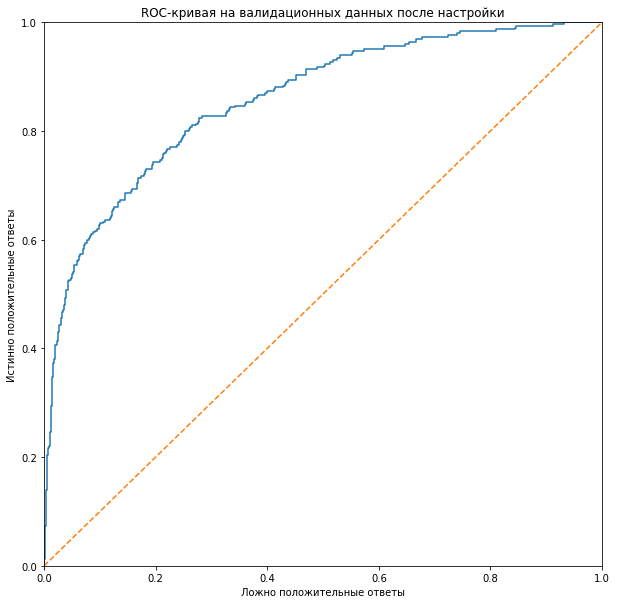

Значение AUC ROC -  0.856825


In [65]:
plot_roc(y_val, model.predict_proba(X_val)[:, 1], 'на валидационных данных после настройки')

Преобразованиями удалось добиться увеличения площади под кривой ROC на 1 процент.

In [66]:
# посмотрим, что конкретно улучшилось
pre_rec(y_val, model.predict(X_val))

Точность предсказаний модели равна:  0.5571030640668524
Полнота предсказаний модели равна:  0.6666666666666666


## Вывод:

1. Для увеличения значения метрики f1 пришлось пожертвовать полнотой - и полнота и точность на валидационных данных стали примерно равны.
2. Преобразованиями удалось добиться увеличения площади под кривой ROC на 1,5 процента (увеличение метрики f1 на примерно 5 %).

# 4. Тестирование модели

Проведем проверку модели на тестовой выборке:

In [67]:
predicted_test = model.predict(X_test)

Посчитаем метрику f1 для тестовых данных:

In [68]:
f1_score(y_test, predicted_test)

0.5922330097087379

Полученное значение удовлетворяет заданному. Строим ROC и считаем AUC

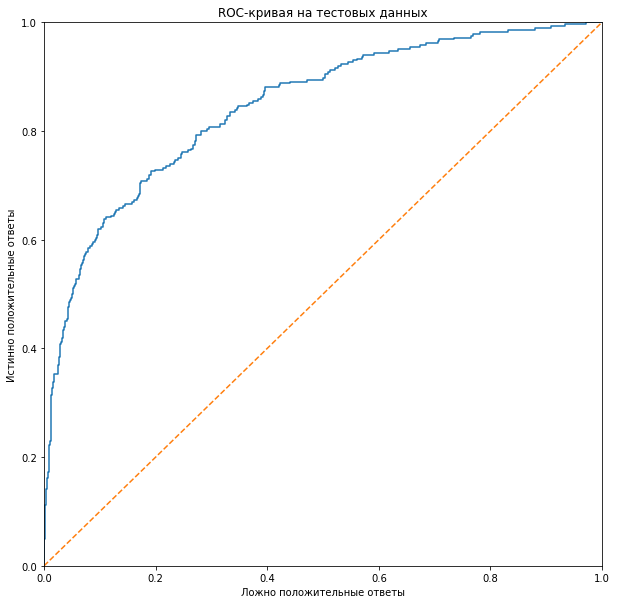

Значение AUC ROC -  0.8447634822090436


In [69]:
plot_roc(y_test, model.predict_proba(X_test)[:, 1], 'на тестовых данных')

## Вывод:

В текущем проекте обучены модели предсказания ухода клиентов из банка.

В результате работы получена модель, среднее гармоническое полноты и точности которой удовлетворяет условию проекта и составляет более 0,59, а именно 0.5922.

По результатам предсказаний модели построена кривая ROC и посчитана площадь под кривой.